In [1]:
import os
import sys
import numpy as np

# Add the path to the custom library to the system path
sys.path.append('..')

# Import custom modules
from src import Tensor, loss_functions, optimizers, metrics
from src.architectures.transformer import Tokenizer, DecoderTransformer
from src.core.utils import data_analysis, data_processing, context_manager

### Constants and hyperparameters

In [2]:
# Constants
dataset_path = os.path.join(os.getcwd(), 'dataset', 'divina_commedia.txt')
tokenizer_path = os.path.join(os.getcwd(), 'checkpoints', 'tokenizer.json')
model_path = os.path.join(os.getcwd(), 'checkpoints', 'language_model')

In [3]:
# Hyperparameters
dropout = 0.2 # The dropout rate
maximum_samples = 19840 # The maximum number of samples to use from the dataset
train_test_split_pct = 0.1 # 90% of the data will be used for training, 10% for testing
train_valid_split_pct = 0.1 # 90% of the training data will be used for training, 10% for validation
batch_size = 32 # The number of samples to use for each batch
grad_accumulation_steps = 1 # The number of steps to accumulate gradients before updating the model
sequence_length = 256 # The size of the sequence length (the context window)
learning_rate = 1e-3 # The learning rate for the optimizer
weight_decay = 0.01 # The weight decay for the optimizer
epochs = 1 # The number of epochs to train the model for
n_embed = 384 # The size of the token embeddings (the dimensionality of the embeddings)
n_attention_heads = 6 # The number of attention heads in the multi-head attention mechanism
n_decoder_blocks = 6 # The number of transformer'decoder blocks in the model

### Data loading

In [4]:
def load_txt_file(path: str) -> str:
    """
    Load a text file from the specified path.
    
    Parameters:
    - path (str): The path to the text file.
    
    Returns:
    - str: The contents of the text file.
    """
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f'The file "{path}" does not exist.')
    
    # Read the file
    with open(path, 'r', encoding='utf-8') as file:
        return file.read()

In [5]:
# Instantiate the tokenizer
tokenizer = Tokenizer()

# Load the state of the tokenizer
tokenizer.load(tokenizer_path)

# Extract the vocabulary size
vocab_size = tokenizer.get_vocab_size()

In [6]:
# Load the text file
text = load_txt_file(dataset_path)

# Encode the text using the tokenizer
encoded_text = tokenizer.encode(text)

# Convert the data to a tensor
data = np.array(encoded_text)

### Data preprocessing

In [7]:
def build_sequences(input_data: np.ndarray, seq_length: int) -> tuple[Tensor, Tensor]:
    """
    Build sequences
    
    Parameters:
    - input_data: np.ndarray, input features
    - target_data: np.ndarray, target values (aligned with input_data)
    - seq_length: int, length of input sequences
    
    Returns:
    - tuple[Tensor, Tensor], input sequences and targets
    """
    
    # Initialize lists to hold sequences and targets
    X, y = [], []
    
    # Iterate over the input data to create sequences
    for i in range(seq_length, len(input_data)):
        # Append the sequence of input and the corresponding target
        X.append(input_data[i-seq_length:i])
        y.append(input_data[i-seq_length+1:i+1])
    
    # Convert the lists to numpy arrays and return as Tensors
    return Tensor(np.array(X, dtype=np.float32)), Tensor(np.array(y, dtype=np.float32))

In [8]:
# Build sequences from the encoded text data
X, y = build_sequences(data, sequence_length)

# Shuffle the data
X_shuffled, y_shuffled = data_processing.shuffle_data((X, y))[0]

# Take only a subset of samples for faster training
X_shuffled = X_shuffled[:maximum_samples]
y_shuffled = y_shuffled[:maximum_samples]

### Data splitting

In [9]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data((X_shuffled, y_shuffled), train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data((X_train, y_train), train_valid_split_pct, shuffle=True)[0]

# Print the dataset information
print('Training set:', X_train.shape(), y_train.shape())
print('Validation set:', X_valid.shape(), y_valid.shape())
print('Testing set:', X_test.shape(), y_test.shape())

Training set: (16071, 256) (16071, 256)
Validation set: (1785, 256) (1785, 256)
Testing set: (1984, 256) (1984, 256)


### Building the model

In [10]:
# Create the language model
language_model = DecoderTransformer(
    name = "Language Model",
    input_dim = vocab_size,
    sequence_length = sequence_length,
    n_embed = n_embed,
    return_sequence = True,
    n_attention_heads = n_attention_heads,
    n_decoder_blocks = n_decoder_blocks,
    dropout = dropout
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy()

### Initializing the model

In [11]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Call the model with a batch of data to initialize it
    language_model(X_train[:batch_size])

In [12]:
# Display the model summary in tree format.
# This is useful since the whole model is composed of submodules,
# therefore, the model summary will be displayed recursively
language_model.summary(recursive=True)

Language Model (DecoderTransformer) [output_shape=(32, 256, 1024), params=11526400]
└── language_model.modules (ModuleList) [output_shape=(32, 256, 1024), params=11526400]
    └── module_list.0 (Decoder) [output_shape=(32, 256, 1024), params=11526400]
        ├── decoder.input_proj (Embedding) [output_shape=(32, 256, 384), params=393216]
        ├── decoder.positional_embedding (Embedding) [output_shape=(256, 384), params=98304]
        ├── decoder.decoder_blocks (ModuleList) [output_shape=?, params=10639872]
        │   ├── module_list.0 (Block) [output_shape=(32, 256, 384), params=1773312]
        │   │   ├── block.layer_norm_1 (LayerNormalization) [output_shape=(32, 256, 384), params=768]
        │   │   ├── block.mlp (MLP) [output_shape=(32, 256, 384), params=1181568]
        │   │   │   ├── mlp.dropout (Dropout) [output_shape=(32, 256, 384), params=0]
        │   │   │   ├── block.mlp.input_dense (Dense) [output_shape=(32, 256, 1536), params=591360]
        │   │   │   └── block.m

### Training the model

In [13]:
# Train the model
history = language_model.fit(
    X_train = X_train,
    y_train = y_train,
    X_valid = X_valid,
    y_valid = y_valid,
    optimizer = optimizer,
    loss_fn = loss_fn,
    batch_size = batch_size,
    epochs = epochs, 
    metrics = [metrics.accuracy],
    gradient_accumulation_steps = grad_accumulation_steps
)

Epoch 1/1 --> loss: 3.2075 - accuracy: 0.33205 | Valid loss: 3.0139 - Valid accuracy: 0.34199                        


In [14]:
# Save the model 
language_model.save(model_path)

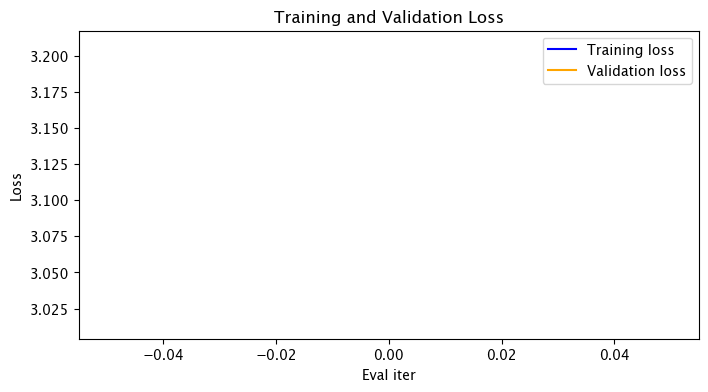

In [15]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = language_model.history["loss"], 
    valid_loss = language_model.history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Eval iter", 
    ylabel = "Loss"
)

### Evaluation

In [16]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Compute the predictions
    predictions = language_model(X_test[:256], batch_size=batch_size, verbose=True)

# Apply the argmax function to the predictions
predictions = Tensor(np.argmax(predictions.data, axis=1), dtype=np.int8)

Processing batch 8/8 - 3064.0 ms/stepp

In [19]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test[:256], predictions)

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

Accuracy: 0.00


### Inference

In [21]:
# Generate some text context from the trained model
context = Tensor(np.zeros((1, 1), dtype=np.int32))

# Iterate over the tokens generated by the transformer
for token in language_model.autoregressive_generation(x=context, num_steps=200, stream=True):
    # Decode the token
    decoded_token = tokenizer.decode([token.data.squeeze().tolist()])

    # Print the decoded token
    print(decoded_token, end='', flush=True)

tema vinotta me, telle do Plenda amente: amarcome brac'io vennel nella,
due suoha
dio rei li nontate tanto egon suote
per sofferto d'in quanto mil vidi mal cammir alla,
ch'uommi volta
grazia, 'om li spestul un li erra mia voltaglio avera
maestro per forte in questo del no dolcipi con ffeondo si inse,
pregirtu petto affetto
col gir 